## Loading libraries

In [1]:
# get automatic reloading & inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = "data/dog-breed/"

## First look at data

In [4]:
!ls {PATH}

labels.csv	models			   submission.csv  test.zip  train
labels.csv.zip	sample_submission.csv.zip  test		   tmp	     train.zip


In [5]:
!ls {PATH}train | wc -l

10222


In [6]:
!ls {PATH}test | wc -l

10357


In [7]:
!ls {PATH}train | head

000bec180eb18c7604dcecc8fe0dba07.jpg
001513dfcb2ffafc82cccf4d8bbaba97.jpg
001cdf01b096e06d78e9e5112d419397.jpg
00214f311d5d2247d5dfe4fe24b2303d.jpg
0021f9ceb3235effd7fcde7f7538ed62.jpg
002211c81b498ef88e1b40b9abf84e1d.jpg
00290d3e1fdd27226ba27a8ce248ce85.jpg
002a283a315af96eaea0e28e7163b21b.jpg
003df8b8a8b05244b1d920bb6cf451f9.jpg
0042188c895a2f14ef64a918ed9c7b64.jpg
ls: write error: Broken pipe


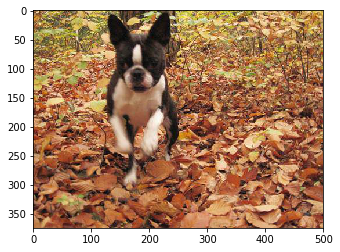

In [8]:
img = plt.imread(f'{PATH}train/000bec180eb18c7604dcecc8fe0dba07.jpg')
plt.imshow(img)

In [9]:
labels_df = pd.read_csv(f'{PATH}labels.csv')

In [10]:
labels_df.shape

(10222, 2)

In [11]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## Building models

In [12]:
val_idxs = get_cv_idxs(10222)

len(val_idxs), val_idxs[:10]

(2044, array([2882, 4514, 7717,   33, 4924,  532, 8028, 5860, 6054, 1543]))

In [13]:
arch = resnext101_64
bs = 32
sz = 224

def get_data(sz, bs=32):
    tfms = tfms_from_model(arch, sz=sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_csv(f'{PATH}','train',f'{PATH}labels.csv',
                                        test_name='test',bs=bs,tfms=tfms,suffix='.jpg',
                                        val_idxs=val_idxs)


data = get_data(sz)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [14]:
learn

Sequential (
  (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout (p = 0.5)
  (2): Linear (4096 -> 512)
  (3): ReLU ()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout (p = 0.5)
  (6): Linear (512 -> 120)
  (7): LogSoftmax ()
)

### Finding optimal learning rate

In [15]:
learn.lr_find()

A Jupyter Widget

 85%|████████▍ | 217/256 [00:02<00:00, 72.58it/s, loss=9.48]


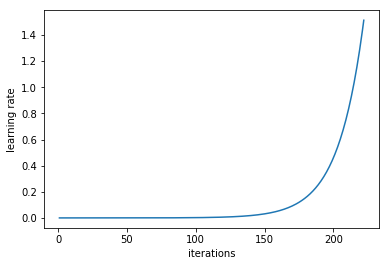

In [16]:
learn.sched.plot_lr()

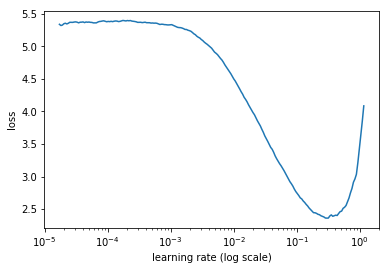

In [17]:
learn.sched.plot()

In [18]:
lr = 1e-2

### Training models

In [19]:
learn.fit(lr, 3)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      0.68171    0.312835   0.916364  
    1      0.369796   0.26304    0.918876                    
    2      0.297174   0.236299   0.92334                     



[0.23629902, 0.92333984375]

In [20]:
learn.precompute = False
learn.fit(lr, 3, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      0.315496   0.216602   0.929618  
    1      0.314261   0.218757   0.931083                    
    2      0.298661   0.215735   0.931571                    



[0.21573514, 0.9315708708018064]

In [21]:
learn.set_data(get_data(299))
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      0.29785    0.20727    0.932547  
    1      0.283642   0.202337   0.933036                    
    2      0.239157   0.20107    0.932059                    
    3      0.273194   0.202739   0.934431                    
    4      0.22572    0.198539   0.930106                    
    5      0.19064    0.188576   0.933036                    
    6      0.183279   0.190861   0.932478                    



[0.19086105, 0.9324776781722903]

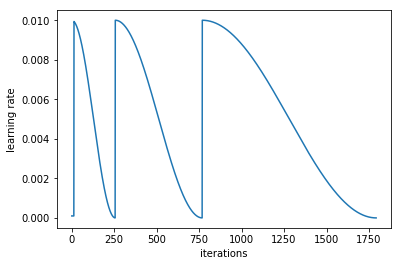

In [23]:
learn.sched.plot_lr()

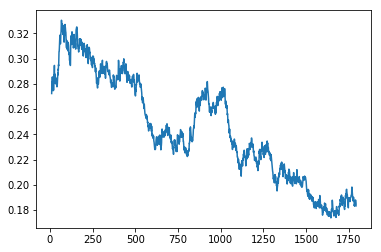

In [24]:
learn.sched.plot_loss()

## Making predictions

In [25]:
log_probs, _ = learn.TTA(is_test=True)

In [26]:
log_probs.shape

(5, 10357, 120)

In [27]:
log_probs[:, :1, :5]

array([[[-14.64911, -14.43249, -19.47838, -16.85315, -18.05673]],

       [[-12.58418, -15.35991, -16.6439 , -15.76497, -16.39049]],

       [[-13.75972, -15.73284, -17.9269 , -16.54045, -17.51222]],

       [[-13.34435, -15.6085 , -17.99096, -15.87241, -17.50453]],

       [[-12.82065, -15.3263 , -15.86991, -15.57646, -15.96639]]], dtype=float32)

In [28]:
avg_log_probs = np.mean(log_probs, axis=0)
avg_log_probs.shape, avg_log_probs[:1, :5]

((10357, 120),
 array([[-13.4316 , -15.29201, -17.58201, -16.12149, -17.08607]], dtype=float32))

In [29]:
probs = np.exp(avg_log_probs); probs.shape

(10357, 120)

## Sumitting to Kaggle

In [30]:
fnames = pd.Series(data.test_ds.fnames); fnames[:10].str[5:-4]

0    fd1a7be32f10493735555e62913c0841
1    5273d42f02b4715cb93845205995ef64
2    442057a3142f4d75a1023db363e2fb54
3    fb03302b030afd122e0f4936c158f6c1
4    511ca6e3539192aa5c8747bb697e0525
5    2e60533a26e589f57fff34711c5ba73c
6    27e4bd954bfe78f9e01338dc5108fadd
7    591566259cbc95dd43b75d77b00aa7a5
8    a51c2803972dff8c7fcc17f6b7eda64d
9    9ace4c5cced4fb88678a5b0a9b3f3cf1
dtype: object

In [31]:
sub_df = pd.DataFrame(probs, columns=data.classes)
sub_df.insert(loc=0, column='id', value=fnames.str[5:-4])

In [32]:
sub_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,fd1a7be32f10493735555e62913c0841,1.468008e-06,2.284359e-07,2.313285e-08,9.966129e-08,3.798513e-08,2.361781e-09,1.431691e-08,1.737571e-08,7.311554e-08,...,5.356921e-06,3.824248e-08,1.795493e-07,8.105832e-09,2.220057e-08,7.798965e-08,5.200433e-09,2.351730e-09,1.502894e-07,7.037733e-08
1,5273d42f02b4715cb93845205995ef64,9.374758e-06,1.487787e-05,5.892922e-06,6.188494e-06,1.516125e-06,2.896341e-07,2.889436e-05,8.101644e-07,7.941990e-07,...,8.010606e-08,2.072956e-07,5.104546e-06,3.953803e-07,5.990517e-05,4.494437e-07,8.784193e-07,1.188303e-05,1.067356e-05,9.022828e-07
2,442057a3142f4d75a1023db363e2fb54,7.393410e-08,3.525882e-06,3.192013e-08,5.872815e-06,1.609576e-07,7.049448e-06,4.516571e-08,4.922821e-07,2.187993e-06,...,2.317047e-08,5.557685e-07,3.873946e-06,1.023733e-04,5.294036e-06,1.470066e-08,1.160360e-07,1.976784e-07,1.442799e-07,6.115421e-08
3,fb03302b030afd122e0f4936c158f6c1,7.487911e-05,3.016616e-07,2.040887e-08,4.179839e-08,8.620652e-09,1.260165e-08,9.918114e-08,2.268382e-08,3.788075e-07,...,7.351570e-06,5.034978e-08,6.797476e-08,1.653158e-08,7.647415e-09,5.660899e-09,2.635835e-08,3.943032e-08,7.869295e-09,8.309532e-05
4,511ca6e3539192aa5c8747bb697e0525,2.813699e-08,2.631491e-07,8.996441e-07,3.426680e-08,7.703490e-08,2.977684e-07,9.198094e-07,3.979661e-08,5.789802e-07,...,3.768538e-05,1.874176e-06,3.522221e-07,2.436083e-09,2.824274e-07,4.703019e-07,4.599139e-06,2.920821e-08,2.216707e-07,7.833672e-06


In [33]:
sub_df.to_csv(f'{PATH}submission.csv', index=False)